In [1]:
# @title 1. Setup & Mount Drive
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import ipywidgets as widgets
from IPython.display import display, clear_output

# Mount Google Drive
drive.mount('/content/drive')

# Visual Settings
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # Silence warnings
%matplotlib inline
print("✅ Libraries Loaded and Drive Mounted")

Mounted at /content/drive
✅ Libraries Loaded and Drive Mounted


In [2]:
# @title 2. Configuration { run: "auto" }

# @markdown ### 📂 Data Source
# @markdown Enter the path to your data folder on Drive:
BASE_PATH = "/content/drive/MyDrive/data/" # @param {type:"string"}

# @markdown ### ⚙️ Analysis Thresholds
# @markdown Minimum transactions to consider a center "Active":
MIN_TRANSACTIONS = 10 # @param {type:"integer"}

print(f"📂 Reading data from: {BASE_PATH}")
print(f"⚙️ Activity Threshold set to: {MIN_TRANSACTIONS}")

📂 Reading data from: /content/drive/MyDrive/data/
⚙️ Activity Threshold set to: 10


In [4]:
# @title 3. Define Helper Functions

def load_and_clean_dataset(folder_name, numeric_cols):
    """Loads CSVs, standardizes columns, and cleans data."""
    file_pattern = f"{BASE_PATH}{folder_name}/*.csv"
    files = glob.glob(file_pattern)

    if not files:
        print(f"⚠️ Warning: No files found in {folder_name}")
        return pd.DataFrame()

    df_list = [pd.read_csv(f) for f in files]
    df = pd.concat(df_list, ignore_index=True)

    # Standardize
    df.columns = df.columns.str.lower().str.strip()
    df = df.dropna(subset=['state', 'district', 'pincode'])
    for col in ['state', 'district']:
        df[col] = df[col].str.upper().str.strip()
    df['pincode'] = df['pincode'].astype(str).str.split('.').str[0] # Handle .0 floats

    # Convert Numerics
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    return df

def calculate_activity_proxy(row):
    """Weighted Activity: 1.0 for Updates, 0.5 for Enrolments"""
    return row['total_demographic_activity'] + (row['total_enrolment_activity'] * 0.5)

In [5]:
# @title 4. Run Analysis Pipeline

def run_pipeline():
    print("--- 🚀 Starting Data Pipeline ---")

    # 1. Load
    print("⏳ Loading Datasets...")
    biometric = load_and_clean_dataset("biometric", ['bio_age_5_17'])
    enrolment = load_and_clean_dataset("enrolment", ['age_0_5', 'age_5_17', 'age_18_greater'])
    demographic = load_and_clean_dataset("demographic", ['demo_age_5_17', 'demo_age_17_'])

    # 2. Aggregate
    print("🔄 Aggregating Data...")
    child_bio = biometric.groupby(['state', 'district', 'pincode'], as_index=False)['bio_age_5_17'].sum()
    child_bio.rename(columns={'bio_age_5_17': 'child_biometric_updates'}, inplace=True)

    enrolment['total_enrolment'] = enrolment['age_0_5'] + enrolment['age_5_17'] + enrolment['age_18_greater']
    enrol_sum = enrolment.groupby(['state', 'district', 'pincode'], as_index=False)['total_enrolment'].sum()

    demographic['total_demo'] = demographic['demo_age_5_17'] + demographic['demo_age_17_']
    demo_sum = demographic.groupby(['state', 'district', 'pincode'], as_index=False)['total_demo'].sum()

    # 3. Merge
    print("🔗 Merging Sources...")
    master = enrol_sum.merge(demo_sum, on=['state', 'district', 'pincode'], how='outer')
    master = master.merge(child_bio, on=['state', 'district', 'pincode'], how='left').fillna(0)

    # 4. Indicators
    master['total_enrolment_activity'] = master['total_enrolment'] # Mapping for helper
    master['total_demographic_activity'] = master['total_demo']    # Mapping for helper
    master['adult_activity_proxy'] = master.apply(calculate_activity_proxy, axis=1)

    # Filter Active Centers
    median_act = master['adult_activity_proxy'].median()
    cutoff = max(median_act, MIN_TRANSACTIONS)
    active_centers = master[master['adult_activity_proxy'] > cutoff].copy()

    # Calculate Risk
    active_centers['child_conversion_rate'] = (
        active_centers['child_biometric_updates'] / (active_centers['adult_activity_proxy'] + 1)
    )
    risk_thresh = active_centers['child_conversion_rate'].quantile(0.25)
    if risk_thresh == 0: risk_thresh = 0.001

    active_centers['is_neglected'] = active_centers['child_conversion_rate'] <= risk_thresh
    high_risk = active_centers[active_centers['is_neglected']].sort_values(by='adult_activity_proxy', ascending=False)

    print(f"\n✅ Pipeline Complete.")
    print(f"   - Total Centers: {len(master)}")
    print(f"   - Active Centers: {len(active_centers)}")
    print(f"   - High Risk Locations: {len(high_risk)}")

    return active_centers, high_risk

# Run and store in global variables
active_centers_df, high_risk_df = run_pipeline()

--- 🚀 Starting Data Pipeline ---
⏳ Loading Datasets...
🔄 Aggregating Data...
🔗 Merging Sources...

✅ Pipeline Complete.
   - Total Centers: 31922
   - Active Centers: 15959
   - High Risk Locations: 3990


/tmp/ipython-input-1930552124.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette='Reds_r', ax=axes[1])


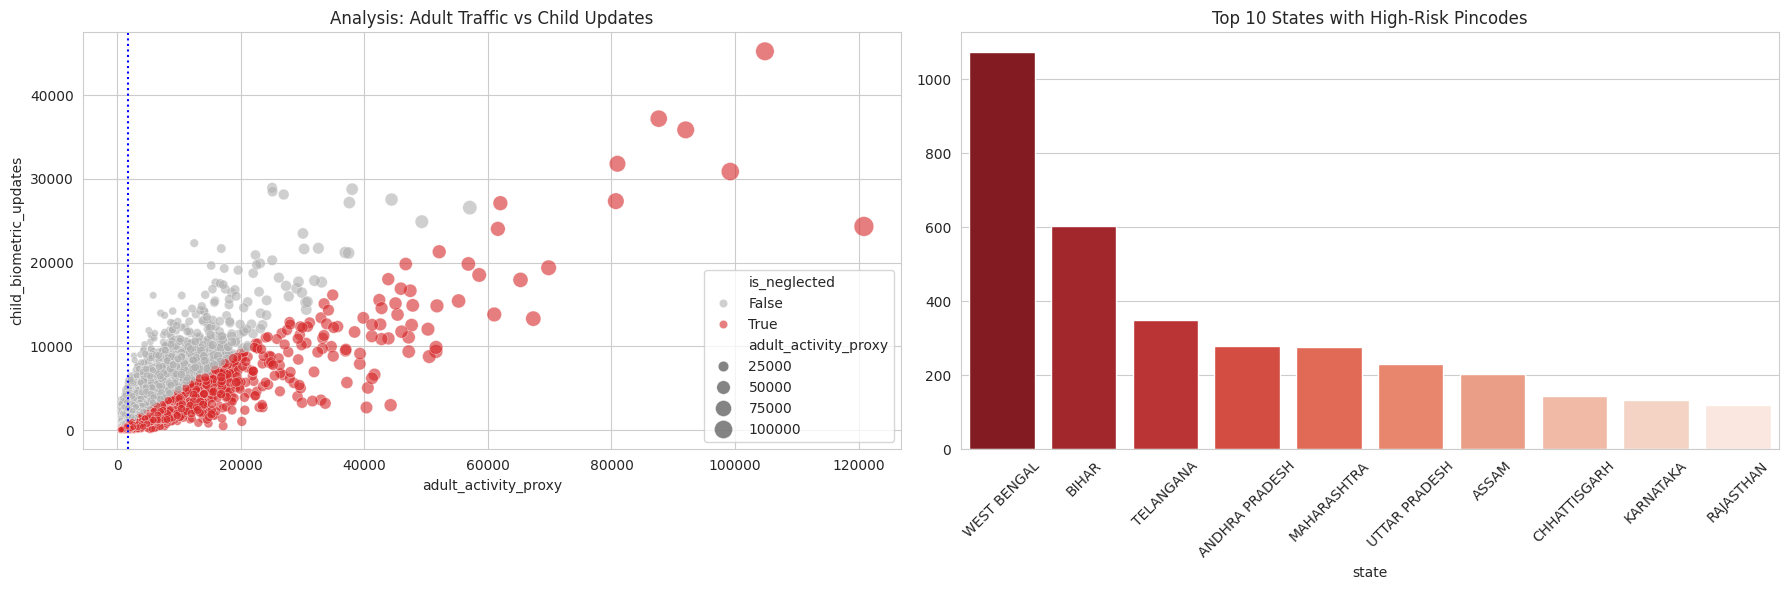

In [6]:
# @title 5. Global Dashboard
# @markdown Run this to see the overall high-level metrics.

def plot_dashboard(active_df, risk_df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Chart 1: The "Quadrant of Neglect"
    sns.scatterplot(
        data=active_df,
        x='adult_activity_proxy', y='child_biometric_updates',
        hue='is_neglected', palette={True: '#D62728', False: '#B0B0B0'},
        size='adult_activity_proxy', sizes=(20, 200), alpha=0.6, ax=axes[0]
    )
    axes[0].set_title("Analysis: Adult Traffic vs Child Updates")
    axes[0].axvline(active_df['adult_activity_proxy'].median(), color='blue', ls=':')

    # Chart 2: State Imbalance Volume
    state_counts = risk_df['state'].value_counts().head(10)
    sns.barplot(x=state_counts.index, y=state_counts.values, palette='Reds_r', ax=axes[1])
    axes[1].set_title("Top 10 States with High-Risk Pincodes")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_dashboard(active_centers_df, high_risk_df)

🔎 Analyzing State Level: KERALA...


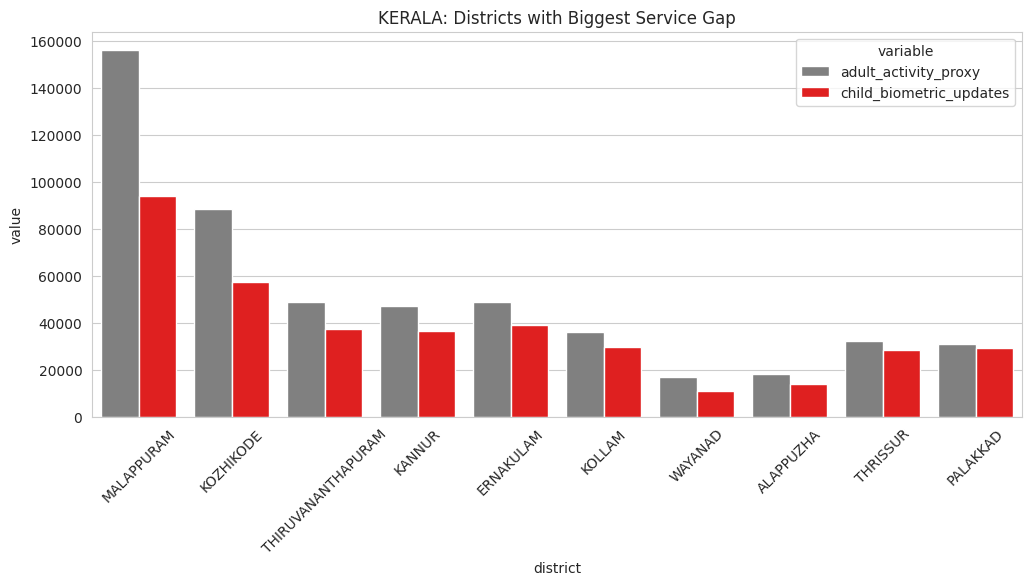

In [10]:
# @title 🔍 6. Interactive State & District Drill-Down
# @markdown Type a State or District name below to generate a specific report.

target_name = "KERALA" # @param {type:"string"}
analysis_type = "State Level" # @param ["State Level", "District Level"]

def analyze_location(name, type_mode):
    name = name.upper().strip()
    print(f"🔎 Analyzing {type_mode}: {name}...")

    if type_mode == "State Level":
        # State Logic
        subset = active_centers_df[active_centers_df['state'] == name]
        if subset.empty:
            print("❌ State not found. Check spelling.")
            return

        district_view = subset.groupby('district').agg({
            'adult_activity_proxy': 'sum',
            'child_biometric_updates': 'sum'
        }).reset_index()

        district_view['gap'] = district_view['adult_activity_proxy'] - district_view['child_biometric_updates']
        top_gaps = district_view.sort_values('gap', ascending=False).head(10)

        # Plot
        top_gaps = top_gaps.melt('district', ['adult_activity_proxy', 'child_biometric_updates'])
        plt.figure(figsize=(12, 5))
        sns.barplot(data=top_gaps, x='district', y='value', hue='variable', palette=['gray', 'red'])
        plt.title(f"{name}: Districts with Biggest Service Gap")
        plt.xticks(rotation=45)
        plt.show()

    elif type_mode == "District Level":
        # District Logic
        subset = active_centers_df[active_centers_df['district'] == name]
        if subset.empty:
            print("❌ District not found.")
            return

        # Show table of worst pincodes
        worst_pincodes = subset[subset['is_neglected']].sort_values('adult_activity_proxy', ascending=False)
        print(f"\n🚨 Top 5 High-Risk Pincodes in {name}:")
        display(worst_pincodes[['pincode', 'adult_activity_proxy', 'child_biometric_updates']].head(5))

        # Plot
        subset['gap'] = subset['adult_activity_proxy'] - subset['child_biometric_updates']
        top_pins = subset.sort_values('gap', ascending=False).head(10)
        top_pins = top_pins.melt('pincode', ['adult_activity_proxy', 'child_biometric_updates'])

        plt.figure(figsize=(12, 5))
        sns.barplot(data=top_pins, x='pincode', y='value', hue='variable', palette=['gray', 'red'])
        plt.title(f"{name}: Top Pincodes with Service Gap")
        plt.show()

analyze_location(target_name, analysis_type)